In [1]:
from pathlib import Path
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

plt.style.use([
    # "dark_background",
    "https://raw.githubusercontent.com/cfrontin/tools_cvf/refs/heads/main/tools_cvf/stylesheet_cvf.mplstyle",
    "https://raw.githubusercontent.com/cfrontin/tools_cvf/refs/heads/main/tools_cvf/stylesheet_nrel.mplstyle",
])

In [2]:
# problem parameters
power_rated = 22000000.0/1.0e6  # MW
production_ref = power_rated*1.0e6*8760  # Wh
mass_ref0 = 6.5e6  # kg
mass_ref1 = 10.0e6  # kg
cf_ref0 = 0.45
cf_ref1 = 0.60

In [3]:
run_dir = Path.cwd()
output_dir = run_dir / "outputs" / "11_ps_check_doe"

# load the dataframe
df_ML = pd.read_csv(output_dir / "ML_DB.csv")
print(f"columns available: {df_ML.columns.tolist()}")

# get the problem variables
with open(output_dir / "problem_vars.yaml", 'r') as f:
    problem_vars = yaml.safe_load(f)
pv_DV = dict(problem_vars["design_vars"])
pv_constr = dict(problem_vars["constraints"])
pv_objs = dict(problem_vars["objectives"])

columns available: ['tune_rosco_ivc.ps_percent', 'floatingse.system_structural_mass', 'floating.jointdv_0', 'floating.jointdv_1', 'floating.memgrp1.outer_diameter_in', 'rotorse.rp.AEP', 'feasibility', 'pareto_rank', 'pareto', 'pareto_rank_noconstraint', 'pareto_noconstraint', 'raft.Max_PtfmPitch_lower', 'raft.Max_PtfmPitch_upper', 'raft.max_nac_accel_lower', 'raft.max_nac_accel_upper', 'raft.pitch_period_lower', 'raft.pitch_period_upper', 'floatingse.constr_draft_heel_margin_lower', 'floatingse.constr_draft_heel_margin_upper', 'floatingse.constr_fairlead_wave_lower', 'floatingse.constr_fairlead_wave_upper', 'floatingse.constr_freeboard_heel_margin_lower', 'floatingse.constr_freeboard_heel_margin_upper', 'floatingse.metacentric_height_pitch_lower', 'floatingse.metacentric_height_pitch_upper', 'floatingse.metacentric_height_roll_lower', 'floatingse.metacentric_height_roll_upper']


In [4]:
df_ML_normalized = df_ML[[
    *list(pv_DV.keys()),
    *list(pv_objs.keys()),
    "feasibility",
]]

for DV in pv_DV.keys():
    df_ML_normalized.loc[:, DV] = (df_ML_normalized[DV] - pv_DV[DV]["lower"])/(pv_DV[DV]["upper"] - pv_DV[DV]["lower"])
df_ML_normalized.loc[:, "rotorse.rp.AEP"] = (df_ML_normalized["rotorse.rp.AEP"]*1000.0/production_ref - cf_ref0)/(cf_ref1 - cf_ref0)  # convert from kWh then normalize to CF, normalize on CF
df_ML_normalized.loc[:, "floatingse.system_structural_mass"] = (df_ML_normalized["floatingse.system_structural_mass"] - mass_ref0)/(mass_ref1 - mass_ref0)  # normalize on mass

In [5]:
df_ML_normalized.min()

floating.jointdv_0                    0.000167
floating.jointdv_1                    0.000167
floating.memgrp1.outer_diameter_in    0.000167
tune_rosco_ivc.ps_percent             0.000167
floatingse.system_structural_mass     0.080634
rotorse.rp.AEP                        0.180672
feasibility                              False
dtype: object

In [6]:
df_ML_normalized.max()

floating.jointdv_0                    0.999833
floating.jointdv_1                    0.999833
floating.memgrp1.outer_diameter_in    0.999833
tune_rosco_ivc.ps_percent             0.999833
floatingse.system_structural_mass     0.951114
rotorse.rp.AEP                        0.854216
feasibility                               True
dtype: object

In [7]:
feasibility = df_ML_normalized["feasibility"].astype(float)

X_train, X_test, Y_train, Y_test, F_train, F_test = train_test_split(
    df_ML_normalized[pv_DV.keys()].to_numpy(),
    df_ML_normalized[[*pv_objs.keys()]].to_numpy(),
    df_ML_normalized["feasibility"].astype(float).to_numpy(),
)

In [ ]:
class SupervisedAutoencoder(Model):
    def __init__(
        self,
        input_dim, input_hidden_dim, latent_dim,
        output_hidden_dim, output_dim,
        predictor_hidden_dim, feasibility_hidden_dim,
    ):
        super(SupervisedAutoencoder, self).__init__()

        self.shape = input_dim
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential([
            layers.Dense(input_hidden_dim, activation='relu'),
            layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(output_hidden_dim, activation='sigmoid'),
            layers.Dense(tf.math.reduce_prod(input_dim).numpy(), activation='sigmoid'),
            layers.Reshape(input_dim),
        ])
        self.predictor = tf.keras.Sequential([
            layers.Dense(predictor_hidden_dim, activation='relu'),
            layers.Dense(output_dim, activation='sigmoid'),
        ])
        self.feasibility_classifier = tf.keras.Sequential([
            layers.Dense(feasibility_hidden_dim, activation='relu'),
            layers.Dense(1, activation='sigmoid'),
        ])

    def call(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        y_predicted = self.predictor(z)
        feasibility_predicted = self.feasibility_classifier(z)
        return {
            "x_reconstructed": x_reconstructed,
            "y_predicted": y_predicted,
            "feasibility_predicted": feasibility_predicted,
        }

input_dim = X_train.shape[1:]
output_dim = Y_train.shape[1]
latent_dim = 3
input_hidden_dim = 32
output_hidden_dim = 32
predictor_hidden_dim = 8
feasibility_hidden_dim = 8
alpha = 0.1
beta = 0.6
gamma = 1.0 - alpha - beta

autoencoder = SupervisedAutoencoder(
    input_dim=input_dim,
    input_hidden_dim=input_hidden_dim,
    latent_dim=latent_dim,
    output_hidden_dim=output_hidden_dim,
    output_dim=output_dim,
    predictor_hidden_dim=predictor_hidden_dim,
    feasibility_hidden_dim=feasibility_hidden_dim,
)

In [9]:
autoencoder.compile(
    optimizer='adam',
    loss={
        "x_reconstructed": tf.keras.losses.MeanSquaredError(),
        "y_predicted": tf.keras.losses.MeanSquaredError(),
        "feasibility_predicted": tf.keras.losses.BinaryCrossentropy(),
    },
    loss_weights={
        "x_reconstructed": alpha,
        "y_predicted": beta,
        "feasibility_predicted": gamma,
    }
)

In [10]:
history = autoencoder.fit(
    X_train,
    {"x_reconstructed": X_train, "y_predicted": Y_train, "feasibility_predicted": F_train},
    epochs=128,
    shuffle=True,
    validation_data=(
        X_test,
        {"x_reconstructed": X_test, "y_predicted": Y_test, "feasibility_predicted": F_test},
    ),
)

Epoch 1/128
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - feasibility_predicted_loss: 0.6543 - loss: 0.2302 - x_reconstructed_loss: 0.1070 - y_predicted_loss: 0.0383 - val_feasibility_predicted_loss: 0.6041 - val_loss: 0.2091 - val_x_reconstructed_loss: 0.0838 - val_y_predicted_loss: 0.0317
Epoch 2/128
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - feasibility_predicted_loss: 0.5798 - loss: 0.1982 - x_reconstructed_loss: 0.0818 - y_predicted_loss: 0.0267 - val_feasibility_predicted_loss: 0.5553 - val_loss: 0.1896 - val_x_reconstructed_loss: 0.0780 - val_y_predicted_loss: 0.0244
Epoch 3/128
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - feasibility_predicted_loss: 0.5476 - loss: 0.1827 - x_reconstructed_loss: 0.0780 - y_predicted_loss: 0.0180 - val_feasibility_predicted_loss: 0.5393 - val_loss: 0.1782 - val_x_reconstructed_loss: 0.0738 - val_y_predicted_loss: 0.0145
Epoch 4/128
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - feasibility_predicted_loss: 0.5273 - loss: 0.1731 - x_reconstructed_loss: 0.0745 - y_p

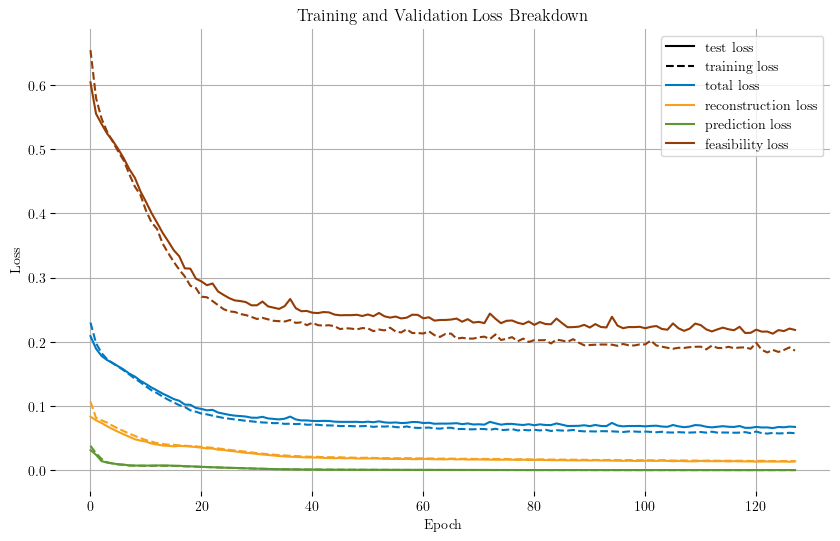

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
m_test = ax.plot([], [], "k-", label="test loss")[-1].get_linestyle()
m_training = ax.plot([], [], "k--", label="training loss")[-1].get_linestyle()
c_total = ax.plot([], [], "-", label="total loss")[-1].get_color()
c_reconstruction = ax.plot([], [], "-", label="reconstruction loss")[-1].get_color()
c_prediction = ax.plot([], [], "-", label="prediction loss")[-1].get_color()
c_feasibility = ax.plot([], [], "-", label="feasibility loss")[-1].get_color()

ax.plot(
    history.history["loss"], m_training,
    c=c_total,
    label="__",
)
ax.plot(
    history.history["val_loss"], m_test,
    c=c_total,
    label="__",
)
ax.plot(
    history.history["x_reconstructed_loss"], m_training,
    c=c_reconstruction,
    label="__",
)
ax.plot(
    history.history["val_x_reconstructed_loss"], m_test,
    c=c_reconstruction,
    label="__",
)
ax.plot(
    history.history["y_predicted_loss"], m_training,
    c=c_prediction,
    label="__",
)
ax.plot(
    history.history["val_y_predicted_loss"], m_test,
    c=c_prediction,
    label="__",
)
ax.plot(
    history.history["feasibility_predicted_loss"], m_training,
    c=c_feasibility,
    label="__",
)
ax.plot(
    history.history["val_feasibility_predicted_loss"], m_test,
    c=c_feasibility,
    label="__",
)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training and Validation Loss Breakdown")
ax.legend()
ax.grid(True)
plt.show()

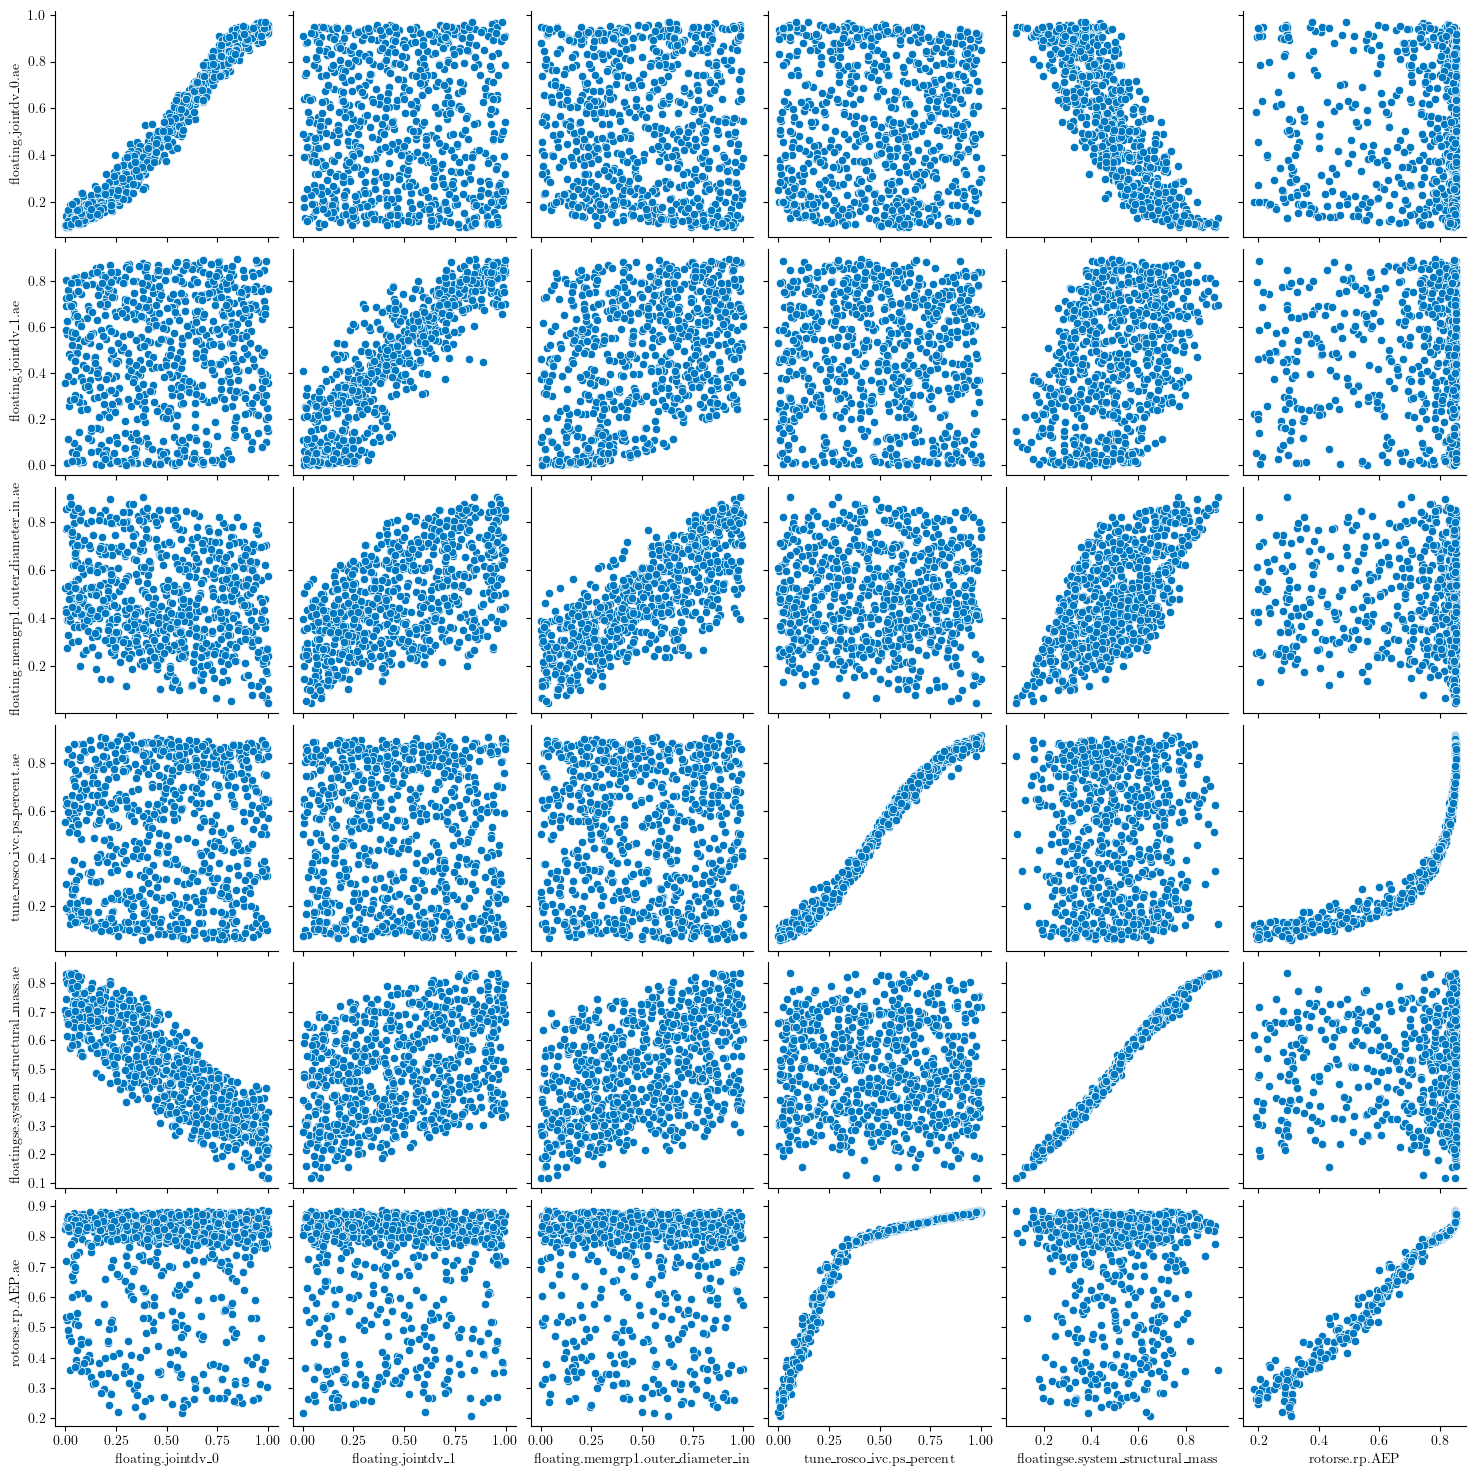

In [12]:
Z_test = autoencoder.encoder(X_test)  # latent-space representation
Xp_test = autoencoder.decoder(Z_test)  # reconstruction from latent space
Yp_test = autoencoder.predictor(Z_test)  # prediction from latent space
Fp_test = autoencoder.feasibility_classifier(Z_test)

df_test = pd.DataFrame(X_test, columns=pv_DV.keys())
for idx, name in enumerate(pv_DV.keys()):
    df_test[f"{name}.ae"] = Xp_test[:, idx]
for idx, name in enumerate(pv_objs.keys()):
    df_test[name] = Y_test[:, idx]
    df_test[f"{name}.ae"] = Yp_test[:, idx]
df_test["feasibility"] = F_test
df_test["feasibility.ae"] = Fp_test
sns.pairplot(
    df_test,
    x_vars=list(pv_DV.keys())+list(pv_objs.keys()),
    y_vars=[f"{name}.ae" for name in list(pv_DV.keys())+list(pv_objs.keys())],
)

In [ ]:
cmtx = confusion_matrix(F_test, Fp_test > 0.5, normalize="all")
print(
    f"true feasible,   autoencoder feasible:   {cmtx[1, 1]*100:.02f}%\n"
    f"true infeasible, autoencoder infeasible: {cmtx[0, 0]*100:.02f}%\n"
    f"true feasible, autoencoder infeasible:   {cmtx[1, 0]*100:.02f}% (false negatives)\n"
    f"true infeasible, autoencoder feasible:   {cmtx[0, 1]*100:.02f}% (false positives)"
)

true feasible,   autoencoder feasible:   67.60%
true infeasible, autoencoder infeasible: 22.00%
true feasible, autoencoder infeasible:   4.40% (false negatives)
true infeasible, autoencoder feasible:   6.00% (false positives)


In [14]:
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# reconstruction error metrics for design variables
mse_reconstruction = mean_squared_error(X_test, Xp_test.numpy())
mae_reconstruction = np.mean(np.abs(X_test - Xp_test.numpy()))
rmse_reconstruction = np.sqrt(mse_reconstruction)
r2_reconstruction = 1 - np.sum((X_test - Xp_test.numpy())**2) / np.sum((X_test - np.mean(X_test, axis=0))**2)

# data statistics
print(f"test set statistics:")
print(f"\tmeans: {np.mean(X_test, axis=0)}")
print(f"\tvariances: {np.var(X_test, axis=0)}")
print(f"\tst. dev: {np.std(X_test, axis=0)}")

# output reconstruction metrics
print(f"test set reconstruction:")
print(f"\tMSE: {mse_reconstruction:.6f}")
print(f"\tMAE: {mae_reconstruction:.6f}")
print(f"\tRMSE: {rmse_reconstruction:.6f}")
print(f"\tR2: {r2_reconstruction:.6f}")

# prediction error metrics for objectives
mse_prediction = mean_squared_error(Y_test, Yp_test.numpy())
mae_prediction = np.mean(np.abs(Y_test - Yp_test.numpy()))
rmse_prediction = np.sqrt(mse_prediction)
r2_prediction = 1 - np.sum((Y_test - Yp_test.numpy())**2) / np.sum((Y_test - np.mean(Y_test, axis=0))**2)

# output prediction metrics
print(f"test set prediction:")
print(f"\tMSE: {mse_prediction:.6f}")
print(f"\tMAE: {mae_prediction:.6f}")
print(f"\tRMSE: {rmse_prediction:.6f}")
print(f"\tR2: {r2_prediction:.6f}")

# Feasibility classification accuracy
accuracy_feasibility = accuracy_score(F_test, (Fp_test.numpy().flatten() > 0.5).astype(float))
precision_feasibility = precision_score(F_test, (Fp_test.numpy().flatten() > 0.5).astype(float))
recall_feasibility = recall_score(F_test, (Fp_test.numpy().flatten() > 0.5).astype(float))
f1_feasibility = f1_score(F_test, (Fp_test.numpy().flatten() > 0.5).astype(float))
roc_auc_feasibility = roc_auc_score(F_test, Fp_test.numpy().flatten())

print(f"test set feasibility:")
print(f"\taccuracy: {accuracy_feasibility:.3f}")
print(f"\tprecision: {precision_feasibility:.3f}")
print(f"\trecall: {recall_feasibility:.3f}")
print(f"\tF1 score: {f1_feasibility:.3f}")
print(f"\tROC AUC: {roc_auc_feasibility:.3f}")


test set statistics:
	means: [0.49799867 0.47500978 0.50950267 0.49869867]
	variances: [0.08215356 0.08093552 0.08165436 0.08223695]
	st. dev: [0.28662442 0.28449168 0.28575227 0.28676986]
test set reconstruction:
	MSE: 0.013991
	MAE: 0.081626
	RMSE: 0.118282
	R2: 0.828850
test set prediction:
	MSE: 0.000583
	MAE: 0.017273
	RMSE: 0.024138
	R2: 0.981920
test set feasibility:
	accuracy: 0.896
	precision: 0.918
	recall: 0.939
	F1 score: 0.929
	ROC AUC: 0.956
